In [1]:
import sympy as sym
import numpy as np
import scipy as sp
from scipy import linalg,spatial,signal

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
def zgosti_mrezo(vozlisca_osn, elementi_osn, approx_elem_size):

    vozlisca = np.copy(vozlisca_osn)
    elementi = np.empty((0,2), int)

    for element in elementi_osn:
        dist = sp.spatial.distance.euclidean(vozlisca_osn[element[0]],vozlisca_osn[element[1]])
        n = np.round(dist/approx_elem_size).astype(int)

        x_coor = np.linspace(vozlisca[element[0],0], vozlisca_osn[element[1],0],n)[1:-1]
        y_coor = np.linspace(vozlisca[element[0],1], vozlisca_osn[element[1],1],n)[1:-1]
        voz = np.block([[x_coor],[y_coor]]).T

        novi_ind_vozlisc = len(vozlisca) + np.arange(len(voz))
        vozlisca = np.append(vozlisca, voz, axis = 0)
        sez_voz = np.block([element[0],novi_ind_vozlisc,element[1]])
        elem = np.array([[sez_voz[_],sez_voz[_+1]] for _ in range(len(sez_voz)-1)])
        elementi = np.append(elementi, elem, axis = 0)
        
    return(vozlisca, elementi)

In [3]:
# PALIČJE

# masna matrika
def M_p(A, L, ρ):

    M = ρ*A*L/6*np.array([
    [2, 0, 1, 0],
    [0, 2, 0, 1],
    [1, 0, 2, 0],
    [0, 1, 0, 2]])
    
    return M

def K_p(A, E, L, α):

    c = np.cos(α)
    s = np.sin(α)
    
    K = A*E/L*np.array([
    [ c**2,   s*c, -c**2,  -s*c],
    [  s*c,  s**2,  -s*c, -s**2],
    [-c**2,  -s*c,  c**2,   s*c],
    [ -c*s, -s**2,   s*c,  s**2]])
    
    return K

In [4]:
# OKVIR
# transformacijska matrika
def T(α):
    
    T = np.array([[ np.cos(α), np.sin(α), 0,         0,         0, 0],
                   [-np.sin(α), np.cos(α), 0,         0,         0, 0],
                   [         0,         0, 1,         0,         0, 0],
                   [         0,         0, 0, np.cos(α), np.sin(α), 0],
                   [         0,         0, 0,-np.sin(α), np.cos(α), 0],
                   [         0,         0, 0,         0,         0, 1]])
        
    return T

# masna matrika
def M_o(A, L, ρ, α):

    M_lok = ρ*A*L*np.array([[1/3,         0,         0, 1/6,         0,         0],
                            [  0,     13/35,  11*L/210,   0,      9/70, -13*L/420],
                            [  0,  11*L/210,  L**2/105,   0,  13*L/420, -L**2/140],
                            [1/6,         0,         0, 1/3,         0,         0],
                            [  0,      9/70,  13*L/420,   0,     13/35, -11*L/210],
                            [  0, -13*L/420, -L**2/140,   0, -11*L/210,  L**2/105]])
    
    return T(α).T @ M_lok @ T(α)

# togostna matrika
def K_o(A, E, I, L, α):

    K_lok = E/L*np.array([[ A,          0,      0, -A,          0,      0],
                          [ 0,  12*I/L**2,  6*I/L,  0, -12*I/L**2,  6*I/L],
                          [ 0,      6*I/L,    4*I,  0,     -6*I/L,    2*I],
                          [-A,          0,      0,  A,          0,      0],
                          [ 0, -12*I/L**2, -6*I/L,  0,  12*I/L**2, -6*I/L],
                          [ 0,      6*I/L,    2*I,  0,     -6*I/L,    4*I]])
    
    return T(α).T @ K_lok @ T(α)

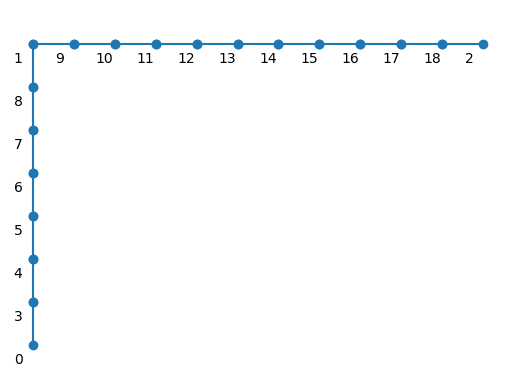

In [5]:
# Podstruktura A - okvir

# podatki
L1 = 0.8 # m
L2 = 1.2 # m
h = 0.030 # m

ρ_A = 2700 # kg /m3
E_A = 70e9 # Pa

A_A = h*h # m^2
I_A = h*h**3/12 # m^4

# osnovna geometrija
vozlisca_osn_A = np.array([[0,0],[0,L1],[L2,L1]])
elementi_osn_A = np.array([[0,1],[1,2]])

# zgostitev mreže
approx_elem_size = 0.1 # m
vozlisca_A, elementi_A = zgosti_mrezo(vozlisca_osn_A, elementi_osn_A, approx_elem_size)

# izris
plt.axis('equal')
[plt.plot(*vozlisca_A[e].T,'-o',c='C0') for e in elementi_A];
[plt.text(*c,n) for n,c in enumerate(vozlisca_A-0.05)];
plt.axis('off');

# zlaganje
n_ps_A = 3*len(vozlisca_A)
M_glob_A = np.zeros((n_ps_A,n_ps_A))
K_glob_A = np.zeros((n_ps_A,n_ps_A))

for element in elementi_A:
    Le = sp.spatial.distance.euclidean(vozlisca_A[element[0]], vozlisca_A[element[1]])
    αe = np.arctan2(np.diff(vozlisca_A[element,1]) , np.diff(vozlisca_A[element,0]))[0]
    ind = (3*element[:,None] + np.array([0, 1, 2])).flatten()
    
    M_glob_A[ind[:,None],ind] += M_o(A_A, Le, ρ_A, αe)
    K_glob_A[ind[:,None],ind] += K_o(A_A, E_A, I_A, Le, αe)

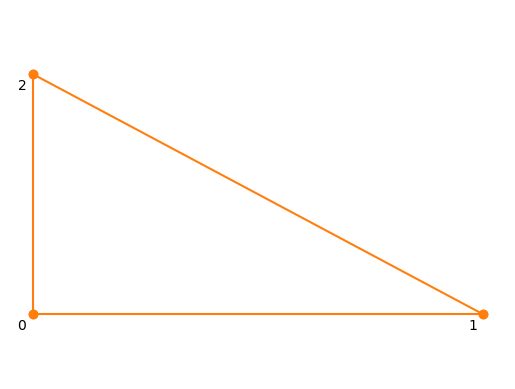

In [6]:
# Podstruktura B - paličje

# podatki
L3 = 0.8 # m
L4 = 1.5 # m
φ = 0*np.pi/4 # rad
d = 0.010 # m

ρ_B = 7800 # kg /m3
E_B = 210e9 # Pa
A_B = np.pi * d**2 / 4 # m^2

# osnovna geometrija
vozlisca_B = np.array([[L2,0],[L2+L4,0],[L2,L3]])
elementi_B = np.array([[0,1],[1,2],[2,0]])

# izris
plt.axis('equal')
[plt.plot(*vozlisca_B[e].T,'-o',c='C1') for e in elementi_B];
[plt.text(*c,n) for n,c in enumerate(vozlisca_B-0.05)];
plt.axis('off');

# zlaganje
n_ps_B = 2*len(vozlisca_B)
M_glob_B = np.zeros((n_ps_B,n_ps_B))
K_glob_B = np.zeros((n_ps_B,n_ps_B))

for element in elementi_B:
    Le = sp.spatial.distance.euclidean(vozlisca_B[element[0]], vozlisca_B[element[1]])
    αe = np.arctan2(np.diff(vozlisca_B[element,1]) , np.diff(vozlisca_B[element,0]))[0]
    ind = (2*element[:,None] + np.array([0, 1])).flatten()
    
    M_glob_B[ind[:,None],ind] += M_p(A_B, Le, ρ_B)
    K_glob_B[ind[:,None],ind] += K_p(A_B, E_B, Le, αe)

In [11]:
# robni pogoji in povezava podstruktur

# A - robni pogoji
ind_vpetih_ps = np.array([0,1,2])
C_A_rp = np.zeros((len(ind_vpetih_ps),n_ps_A))
C_A_rp[np.arange(len(ind_vpetih_ps)),ind_vpetih_ps] = 1

# B - robni pogoji - ročno za boljše razumevanje
C_B_rp = np.array([[0, 0, np.tan(φ), -1, 0, 0]])

C_rp = sp.linalg.block_diag(C_A_rp,C_B_rp)

# AB povezava - ročno za boljše razumevanje
C_A_pov = np.zeros((2,n_ps_A))
C_A_pov[[0,1],[6,7]] = 1

C_B_pov = np.zeros((2,n_ps_B))
C_B_pov[[0,1],[4,5]] = -1

C_pov = np.hstack([C_A_pov,C_B_pov]) 

# združeno
C = np.vstack([C_rp, C_pov])
L_AB = sp.linalg.null_space(C)

# združitev masne in togostne matrike
M_glob_AB = L_AB.T @ sp.linalg.block_diag(M_glob_A, M_glob_B) @ L_AB
K_glob_AB = L_AB.T @ sp.linalg.block_diag(K_glob_A, K_glob_B) @ L_AB
C.shape

(6, 63)

In [8]:
# problem lastnih vrednosti
eig_val, eig_vec = sp.linalg.eig(K_glob_AB, M_glob_AB)

# urejanje po velikosti
_ind = np.argsort(np.abs(eig_val))
eig_val = np.abs(eig_val[_ind])
eig_vec = eig_vec[:,_ind]

eig_freq = np.abs(eig_val)**0.5 / 2 / np.pi

# interpretacija rezultata
eig_vec_A = L_AB[:n_ps_A,:] @ eig_vec
eig_vec_B = L_AB[-n_ps_B:,:] @ eig_vec

In [9]:
# lastne frekvence [Hz]
eig_freq[:6].round(1)

array([  4.7,  18.7,  67.8, 185.1, 253.8, 437.4])

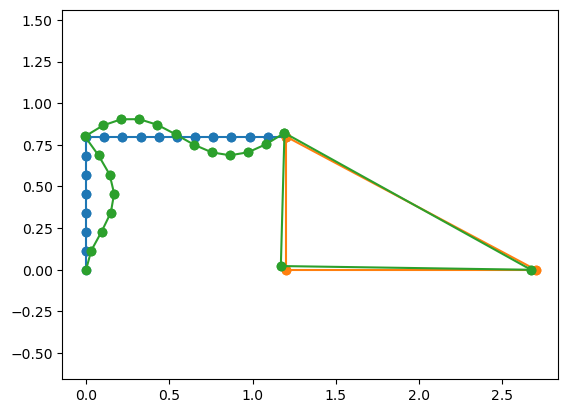

In [10]:
# animacija lastnih oblik
m = 3
s = 2

# podstruktura A
pomiki_x_A = eig_vec_A[0::3,m].real
pomiki_y_A = eig_vec_A[1::3,m].real

# podstruktura B
pomiki_x_B = eig_vec_B[0::2,m].real
pomiki_y_B = eig_vec_B[1::2,m].real

# stacionarni izris
def_vozlisca_A = np.copy(vozlisca_A)
def_vozlisca_A[:,0] += pomiki_x_A * s
def_vozlisca_A[:,1] += pomiki_y_A * s

def_vozlisca_B = np.copy(vozlisca_B)
def_vozlisca_B[:,0] += pomiki_x_B * s
def_vozlisca_B[:,1] += pomiki_y_B * s

# osnovno stanje
plt.axis('equal')
[plt.plot(*vozlisca_A[e].T,'-o',c='C0') for e in elementi_A];
[plt.plot(*vozlisca_B[e].T,'-o',c='C1') for e in elementi_B];

# deformirano stanje
plt.axis('equal')
[plt.plot(*def_vozlisca_A[e].T,'-o',c='C2') for e in elementi_A];
[plt.plot(*def_vozlisca_B[e].T,'-o',c='C2') for e in elementi_B];